# Plant Disease Detection Using Deep Learning

```python
This project aims to classify corn leaf conditions into four categories using deep learning techniques. The conditions include:

```
1. Corn Northern Leaf Blight
2. Corn Healthy
3. Corn Gray Leaf Spot
4. Corn Common Rust
```python
The project implements a convolutional neural network (CNN) For image classification And applies data augmentation to improve model generalization
```

> 1. Import Libraries

In [1]:
# Core Libraries
import numpy as np
import tensorflow as tf
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import os
import glob as gb
import pandas as pd

# TensorFlow Utilities ==>(used in learning and augmantation)
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomHeight, RandomWidth
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, LeakyReLU

#sklearn usage
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
from sklearn.svm import SVC


#logistic regression classifier
from sklearn.linear_model import LogisticRegression

> 2. Dataset Preparation

Define the Dataset Directory:

    The dataset includes images categorized into folders by disease type.

Load the Dataset:

    Use TensorFlow's image_dataset_from_directory to load and preprocess the dataset

In [2]:
# Set parameters
IMG_SIZE = (128, 128)
directory = "Dataset/BangladeshiCrops/BangladeshiCrops/Crop___Disease/Corn"
BATCH_SIZE = 128  # number of images in one step

# Load training dataset
train_dataset = image_dataset_from_directory(
    directory,
    shuffle=True, # get random data
    labels="inferred",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    validation_split=0.1, # make 10% of data to validation
    subset="training",
    color_mode="rgb",
    seed=42,
)
print('-'* 50)

# Load validation dataset
validation_dataset = image_dataset_from_directory(
    directory,
    shuffle=True,
    labels="inferred",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    validation_split=0.1,
    subset="validation", # prepare data for testing
    color_mode="rgb",
    seed=42,
)
print("-" * 50)

# Display class names
class_names = train_dataset.class_names
print(class_names)

Found 3852 files belonging to 4 classes.
Using 3467 files for training.
--------------------------------------------------
Found 3852 files belonging to 4 classes.
Using 385 files for validation.
--------------------------------------------------
['Corn___Common_Rust', 'Corn___Gray_Leaf_Spot', 'Corn___Healthy', 'Corn___Northern_Leaf_Blight']


> 3. Analyze Data Imbalance 

Visualize the distribution of samples across classes to identify potential imbalances.

C:\Users\AHMED\AppData\Local\Temp\ipykernel_19252\106527794.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


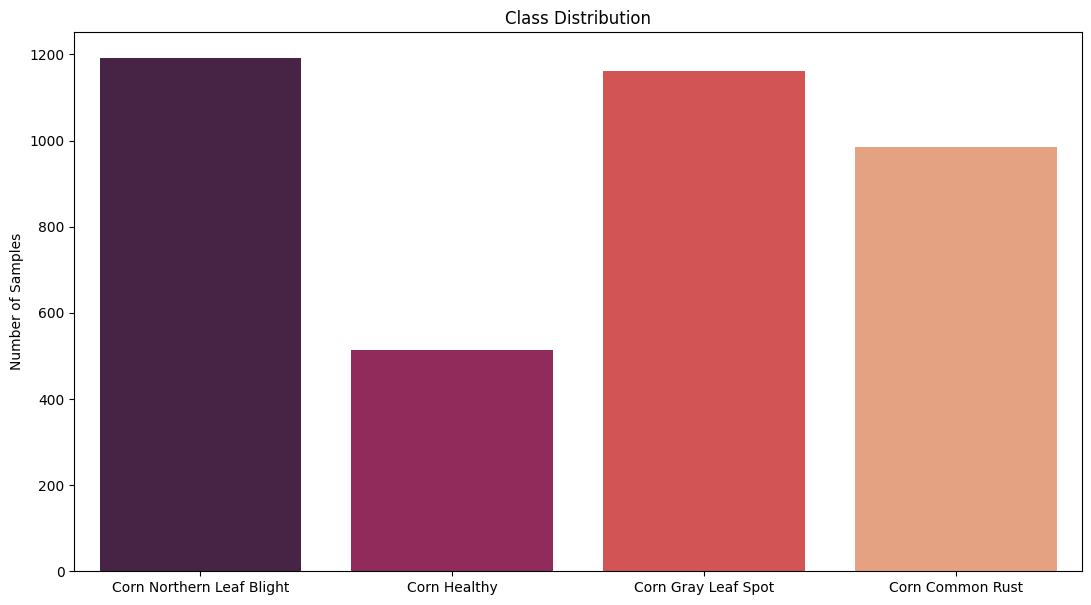

In [3]:
# Analyze data distribution to calculate number of samples in each class
Data_imbalance = []
for folder in os.listdir(directory):
    files = gb.glob(pathname=str(directory + "/" + folder + "/*.*"))
    Data_imbalance.append(len(files))

# Plot data distribution
plt.figure(figsize=(13, 7))
sns.barplot(
    x=[
        "Corn Northern Leaf Blight",
        "Corn Healthy",
        "Corn Gray Leaf Spot",
        "Corn Common Rust",
    ],
    y=Data_imbalance,
    palette="rocket",
)
plt.title("Class Distribution")
plt.ylabel("Number of Samples")
plt.show()

> 4. Compute Class Weights

Handle data imbalance by calculating class weights.

In [4]:
# Compute class weights 
total = sum(Data_imbalance)
class_weight = {
    i: (1 / Data_imbalance[i]) * (total / len(Data_imbalance))
    for i in range(len(Data_imbalance))
}

for cls, weight in class_weight.items():
    print(f"Weight for class {cls}: {weight:.2f}")

Weight for class 0: 0.81
Weight for class 1: 1.88
Weight for class 2: 0.83
Weight for class 3: 0.98


> 5. Data Augmentation

Enhance dataset variability using augmentation techniques like flipping, rotation, and zooming.

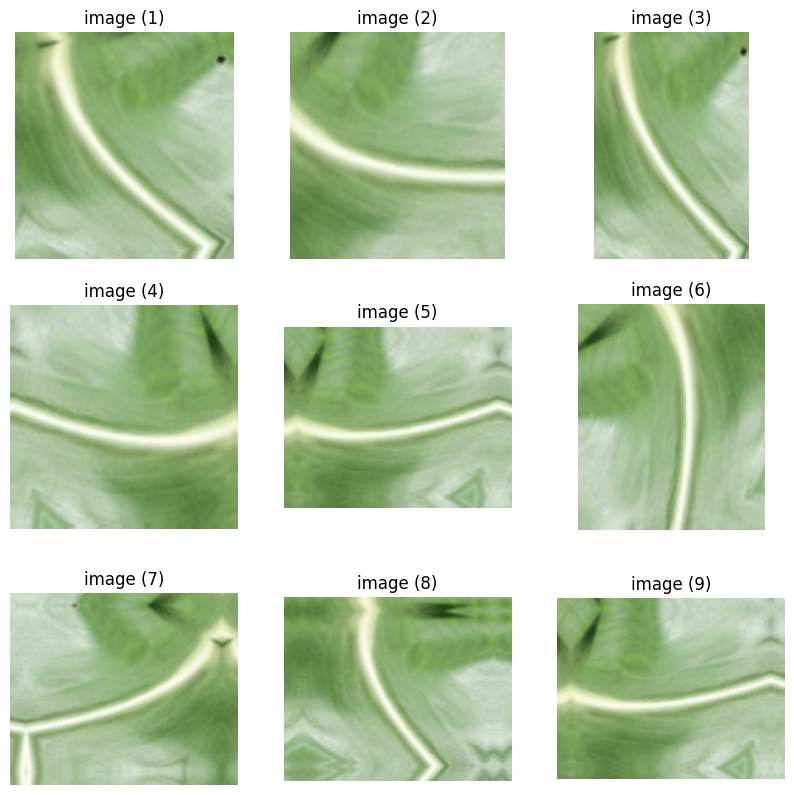

In [5]:
# using data augmentation to avoid overfitting
# Define augmentation layers
data_augmentation = tf.keras.Sequential(
    [
        RandomFlip("horizontal"),
        RandomRotation(0.2),
        RandomZoom(0.2),
        RandomHeight(0.2),
        RandomWidth(0.2),
    ]
)

# Visualize augmented images
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0)) # take a copy og augmented images
        plt.imshow(augmented_image[0] / 255) # using 255 to normalize image 
        plt.title(f"image ({i+1})")
        plt.axis("off")
plt.show()

> 6. Display sample images from each class

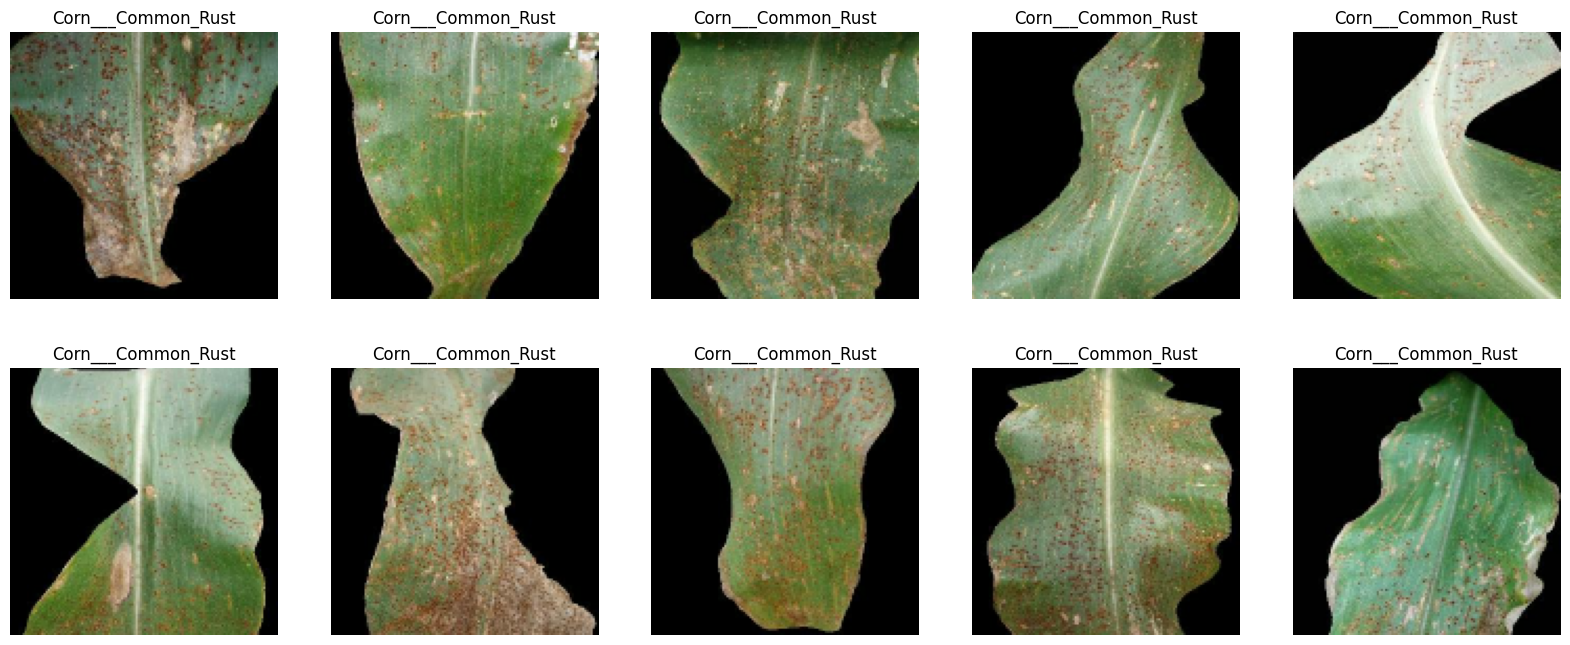

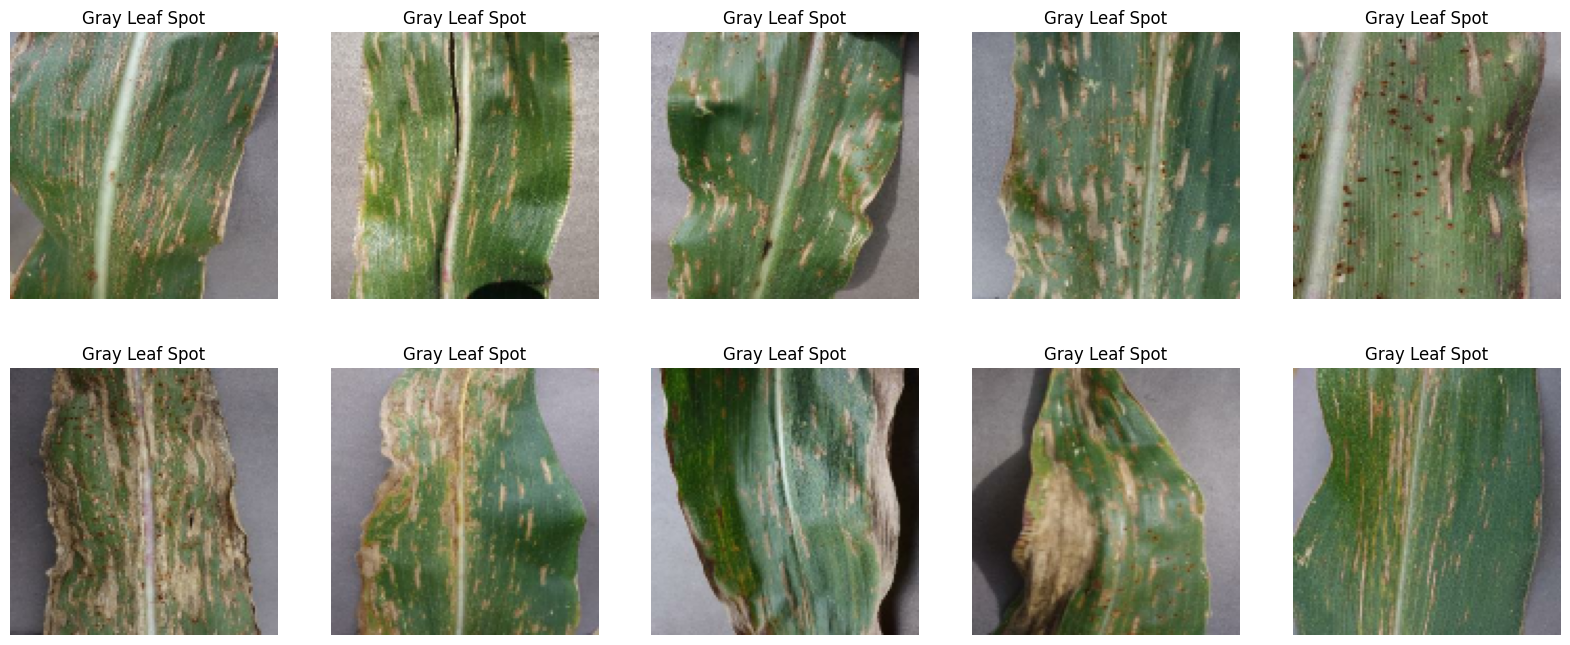

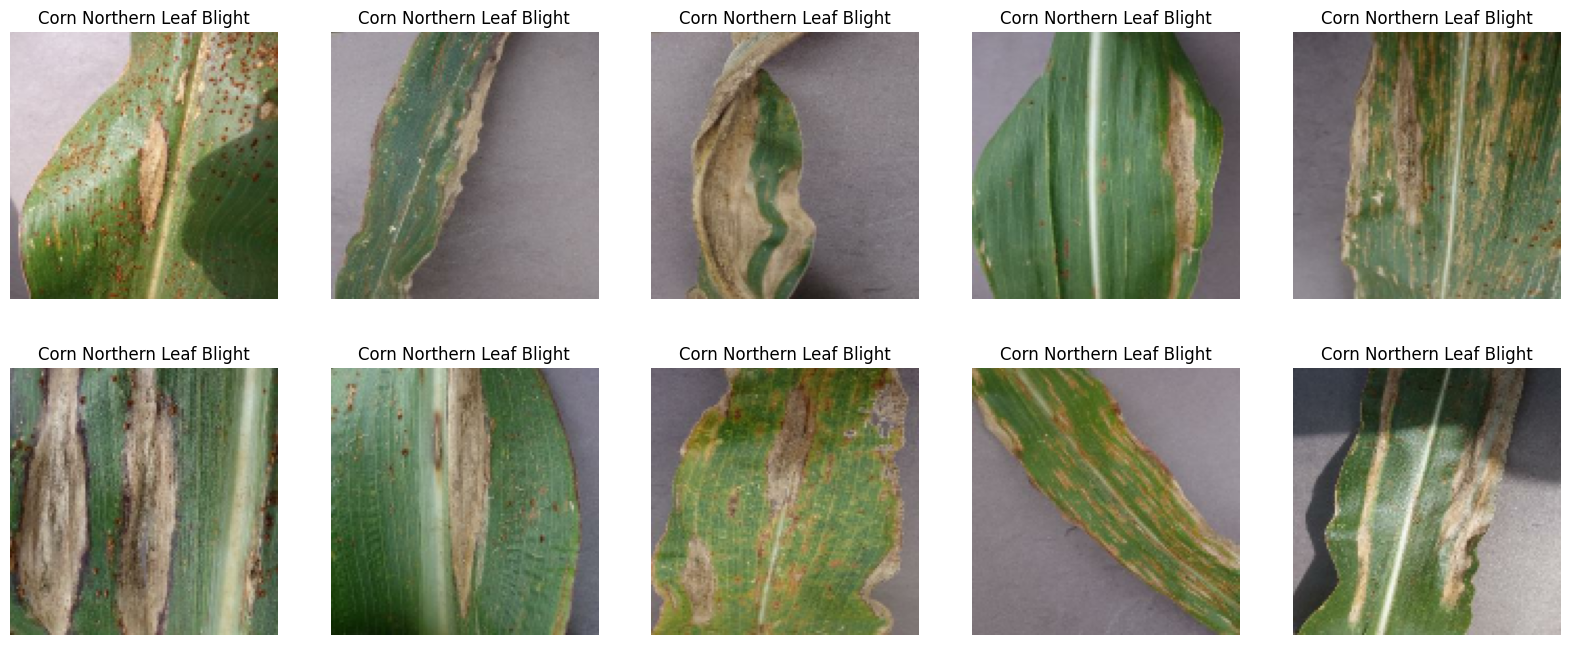

In [6]:
# Display sample images from each class
plt.figure(figsize=(20, 8))
for images, labels in train_dataset.take(1):
    Common_Rust, Gray_Leaf_Spot, Corn_Northern_Leaf_Blight = [],[],[]

    for i in range(100):
        if class_names[labels[i]] == "Corn___Common_Rust":
            Common_Rust.append(images[i].numpy().astype("uint8"))
        elif class_names[labels[i]] == "Corn___Gray_Leaf_Spot":
            Gray_Leaf_Spot.append(images[i].numpy().astype("uint8"))
        elif class_names[labels[i]] == "Corn___Northern_Leaf_Blight":
            Corn_Northern_Leaf_Blight.append(images[i].numpy().astype("uint8"))


    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(Common_Rust[i])
        plt.axis("off")
        plt.title("Corn___Common_Rust")

    plt.figure(figsize=(20, 8))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(Gray_Leaf_Spot[i])
        plt.axis("off")
        plt.title("Gray Leaf Spot")

    plt.figure(figsize=(20, 8))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(Corn_Northern_Leaf_Blight[i])
        plt.axis("off")
        plt.title("Corn Northern Leaf Blight")


AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE) # reduce waiting time & make model better in detection

> 7. Define the Model

Build a CNN model for classification. 

 *to deal with images in an effiecient way and make the accuracy of modeling high*

In [7]:
# Define the model ==> if there is an error , the model will use the backpropagation to reduce the errors
def Plant_Leaf_Model(image_size):
    model = tf.keras.models.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=image_size + (3,)),
            Conv2D(32, (3, 3), activation="relu"), #non-linearity to make output values match with inputs
            MaxPooling2D((2, 2)), #reduce image dimensions
            Conv2D(64, (3, 3), activation="relu"),
            MaxPooling2D((2, 2)),
            Conv2D(128, (3, 3), activation="relu"),
            MaxPooling2D((2, 2)),
            Flatten(), # convert image from 2d to 1d array to enter the level of dence layer
            Dense(128, activation="relu"),
            Dense(4, activation="softmax"),  # 4 classes
        ]
    )

    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],  # loss: measure how much data be lost , the fewer the value of loss, the more accurate the predictiong of true predictions
    )

    return model

> 8. Train the Model

In [8]:
# Create and summarize the model
model = Plant_Leaf_Model(IMG_SIZE)
model.summary() # summarize the data

base_learning_rate = 0.001 # if we increased the value of learning rate the accuracy of total epoches of data decreases
model.compile(
    optimizer=tf.keras.optimizers.Nadam(learning_rate=base_learning_rate),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)

history = model.fit(
    train_dataset,
    verbose=2, 
    epochs=10,
    class_weight=class_weight,
    validation_data=validation_dataset,
)

model.evaluate(validation_dataset, verbose=1)

C:\Users\AHMED\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,156 (12.61 MB)

 Trainable params: 3,305,156 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
28/28 - 38s - 1s/step - accuracy: 0.5858 - loss: 47.4254 - val_accuracy: 0.6104 - val_loss: 0.7775
Epoch 2/10
28/28 - 32s - 1s/step - accuracy: 0.7098 - loss: 0.9484 - val_accuracy: 0.7766 - val_loss: 0.5434
Epoch 3/10
28/28 - 25s - 903ms/step - accuracy: 0.8517 - loss: 0.4257 - val_accuracy: 0.8260 - val_loss: 0.3942
Epoch 4/10
28/28 - 26s - 915ms/step - accuracy: 0.8933 - loss: 0.3192 - val_accuracy: 0.6078 - val_loss: 1.1081
Epoch 5/10
28/28 - 26s - 918ms/step - accuracy: 0.8613 - loss: 0.3999 - val_accuracy: 0.8779 - val_loss: 0.2587
Epoch 6/10
28/28 - 28s - 998ms/step - accuracy: 0.9138 - loss: 0.2438 - val_accuracy: 0.9091 - val_loss: 0.2231
Epoch 7/10
28/28 - 28s - 1s/step - accuracy: 0.9360 - loss: 0.1889 - val_accuracy: 0.7506 - val_loss: 0.7778
Epoch 8/10
28/28 - 28s - 1s/step - accuracy: 0.9279 - loss: 0.2059 - val_accuracy: 0.7714 - val_loss: 0.7413
Epoch 9/10
28/28 - 31s - 1s/step - accuracy: 0.9365 - loss: 0.1933 - val_accuracy: 0.9117 - val_loss: 0.2129
Epoch 

[0.21546030044555664, 0.9012987017631531]

> 9. Visualize predictions 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


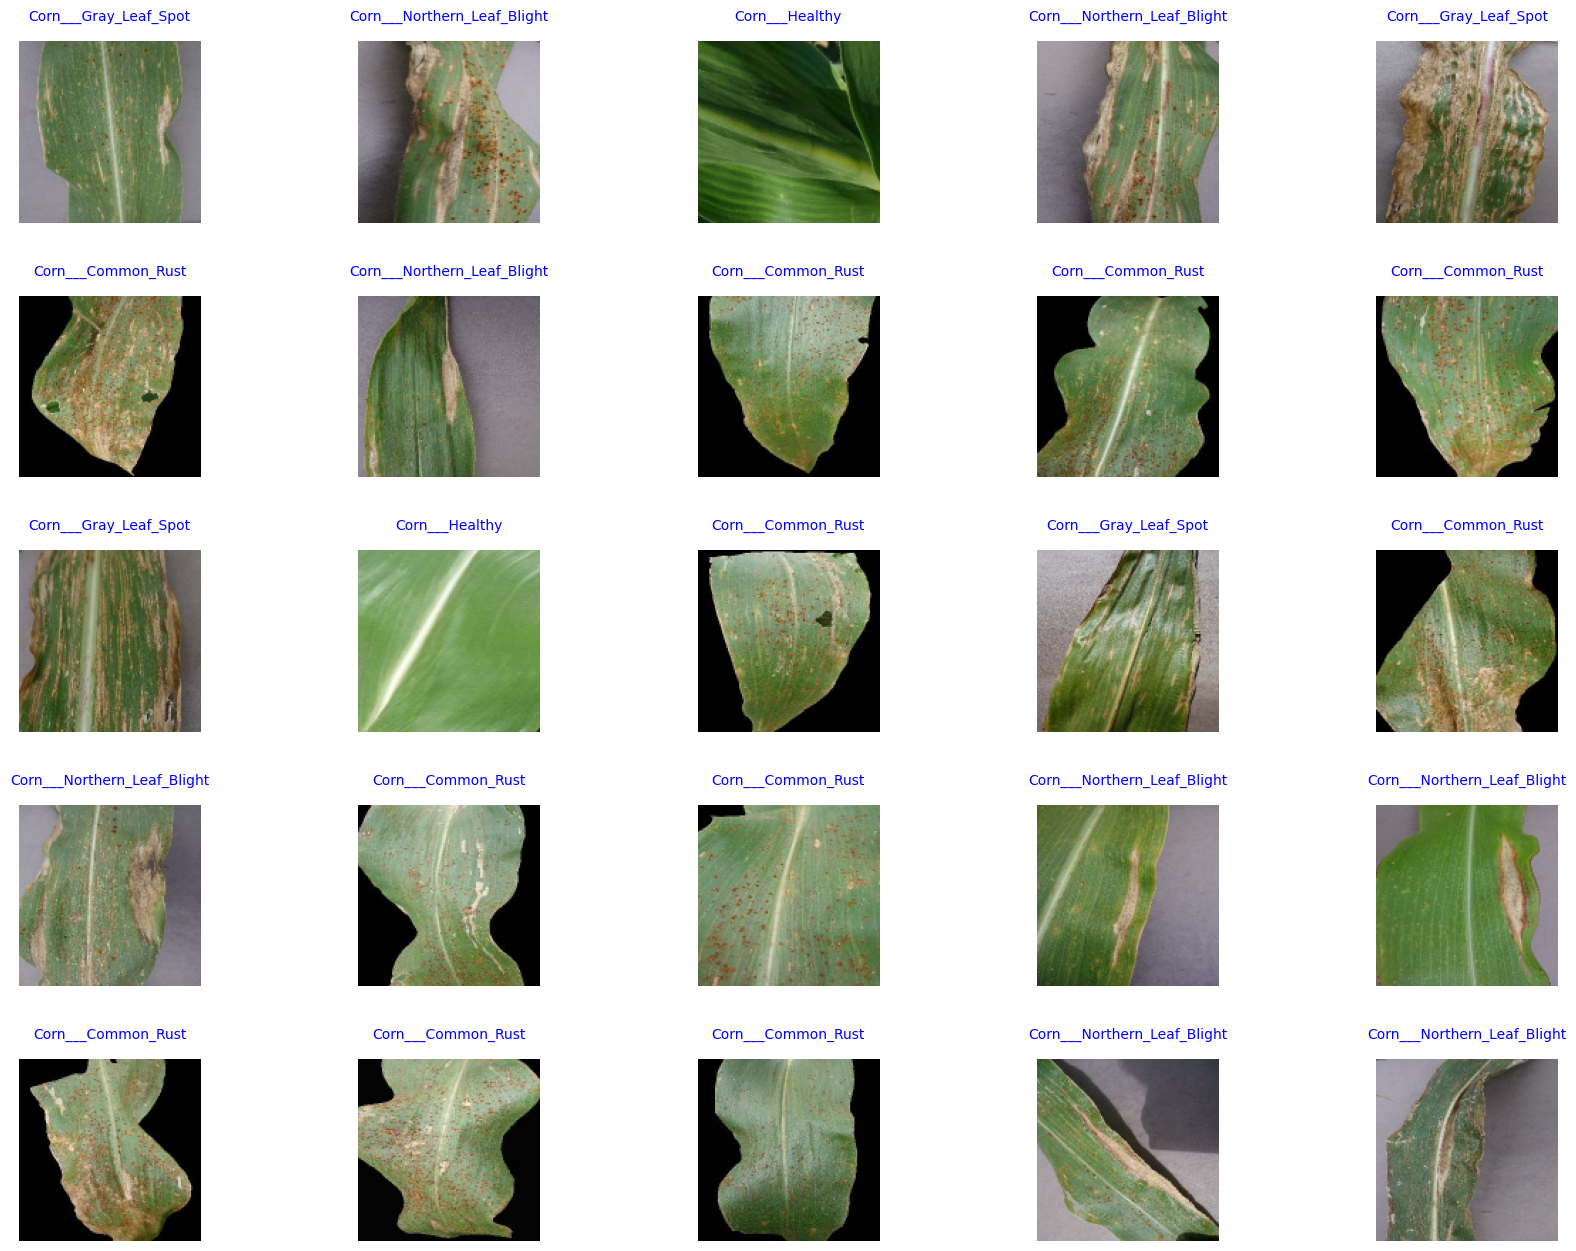

In [9]:
# Plot predictions
plt.figure(figsize=(20, 15))
for images, labels in train_dataset.take(1):
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")
        img2 = tf.expand_dims(images[i].numpy().astype("uint8"), 0)
        predict = model.predict(img2)
        predicted = class_names[np.argmax(predict)]
        actual = class_names[labels[i].numpy()]
        if actual == predicted:
            plt.title(predicted, fontsize=10, color="blue", pad=15)
        else:
            plt.title(actual, fontsize=10, color="red", pad=15)
        plt.subplots_adjust(
            left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4
        )

> 10. Evaluate Performance

Plot accuracy and loss for both training and validation.

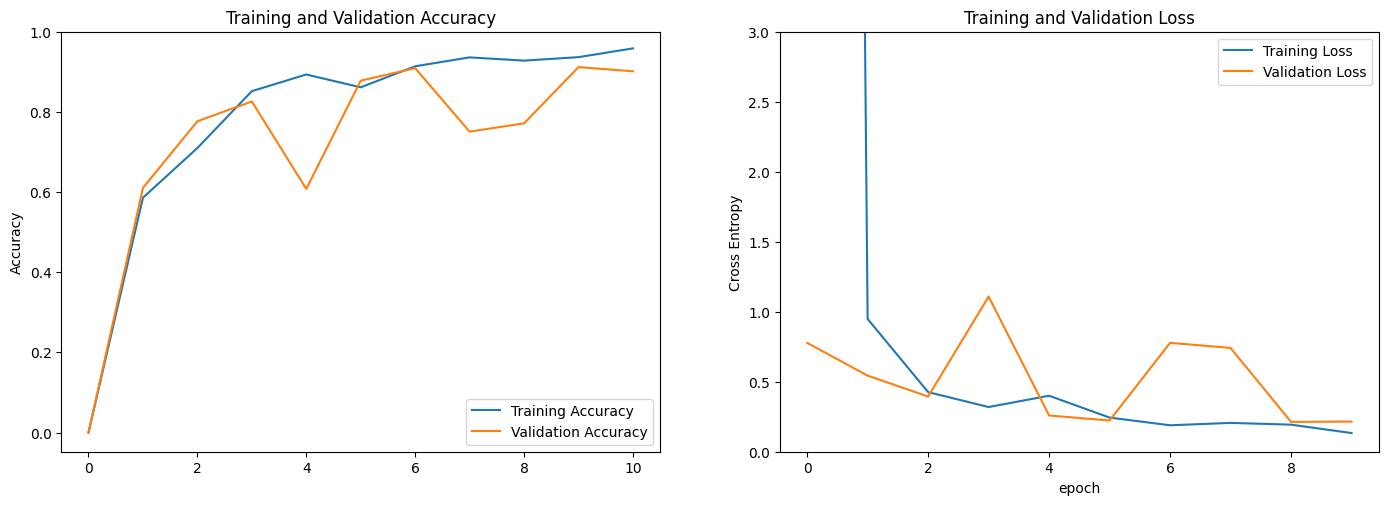

In [10]:
# Plot accuracy and loss
acc = [0.0] + history.history["accuracy"]
val_acc = [0.0] + history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

plt.figure(figsize=(17, 12))
plt.subplot(2, 2, 1)
plt.plot(acc, label="Training Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.ylabel("Accuracy")
plt.ylim([min(plt.ylim()), 1])
plt.title("Training and Validation Accuracy")

plt.subplot(2, 2, 2)
plt.plot(loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.ylabel("Cross Entropy")
plt.ylim([0, 3.0])
plt.title("Training and Validation Loss")
plt.xlabel("epoch")
plt.show()

### 11. Train and Evaluate Machine Learning Models

In [11]:
# Preprocess Dataset for Traditional Machine Learning
def extract_features_labels(dataset):
    images, labels = [], []
    for img_batch, label_batch in dataset:
        for img, label in zip(img_batch, label_batch):
            images.append(tf.image.resize(img, IMG_SIZE).numpy().flatten())
            labels.append(label.numpy())
    return np.array(images), np.array(labels)


train_images, train_labels = extract_features_labels(train_dataset)
val_images, val_labels = extract_features_labels(validation_dataset)

> 11.1. K-Nearest Neighbors (KNN)

In [12]:
# Train and Evaluate KNN
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(
    train_images, train_labels
)  # Assuming train_images and train_labels are prepared
knn_predictions = knn_model.predict(
    val_images
)  # Assuming val_images and val_labels are prepared
print("KNN Accuracy:", accuracy_score(val_labels, knn_predictions))
print(
    "KNN Classification Report:\n", classification_report(val_labels, knn_predictions)
)

KNN Accuracy: 0.812987012987013
KNN Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98       105
           1       0.63      0.38      0.47        58
           2       0.85      0.97      0.90       115
           3       0.67      0.73      0.70       107

    accuracy                           0.81       385
   macro avg       0.78      0.76      0.76       385
weighted avg       0.80      0.81      0.80       385



> 11.2. Logistic Regression

In [13]:
# Train and Evaluate Logistic Regression
log_reg_model = LogisticRegression(max_iter=1000)
log_reg_model.fit(train_images, train_labels)
log_reg_predictions = log_reg_model.predict(val_images)
print("Logistic Regression Accuracy:", accuracy_score(val_labels, log_reg_predictions))
print("Logistic Regression Classification Report:\n",classification_report(val_labels, log_reg_predictions),)

Logistic Regression Accuracy: 0.8493506493506493
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.96      0.97       105
           1       0.60      0.47      0.52        58
           2       0.95      0.98      0.97       115
           3       0.74      0.80      0.77       107

    accuracy                           0.85       385
   macro avg       0.81      0.80      0.81       385
weighted avg       0.84      0.85      0.84       385



> 11.3 SVM

In [ ]:
# Train and Evaluate SVM
svm_model = SVC(kernel="linear", probability=True)
svm_model.fit(train_images, train_labels)
svm_predictions = svm_model.predict(val_images)
print("SVM Accuracy:", accuracy_score(val_labels, svm_predictions))
print(
    "SVM Classification Report:\n", classification_report(val_labels, svm_predictions)
)

### 12. Visualize Confusion Matrices

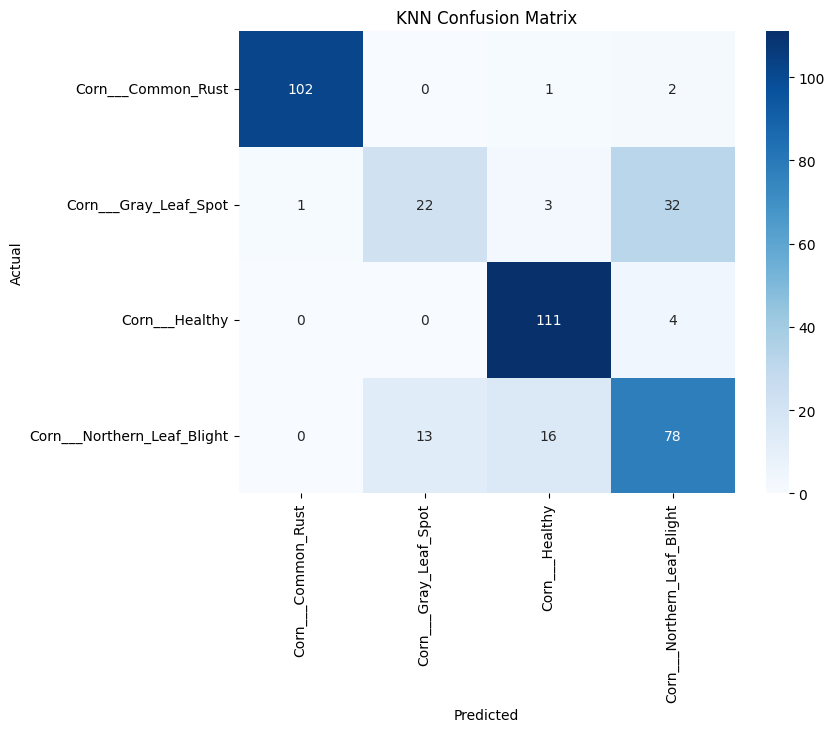

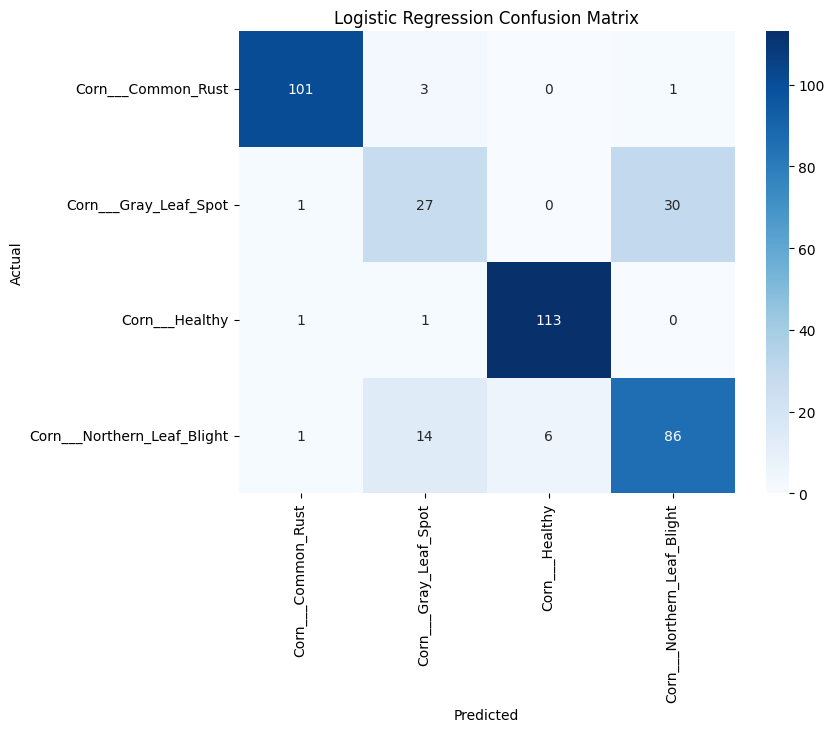

In [ ]:
# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names,
    )
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Plot for KNN
plot_confusion_matrix(val_labels, knn_predictions, "KNN Confusion Matrix")

# Plot for Logistic Regression
plot_confusion_matrix(
    val_labels, log_reg_predictions, "Logistic Regression Confusion Matrix"
)